In [ ]:
#Check for background image in yeo atlas.

In [1]:
#from nilearn import plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image
from nilearn import signal
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiMapsMasker
from nilearn.plotting import plot_roi
import nilearn as nl 
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
import scipy.stats as stats
from sklearn.decomposition import PCA
import seaborn as sns
import os
import glob
import networkx as nx
import ray
import psutil
from nilearn import datasets
from nilearn import surface
from nilearn import plotting

# Homemade functions

In [26]:
ray.shutdown()

num_cpus = psutil.cpu_count(logical=False)

ray.init(num_cpus=4)

@ray.remote
def fit_mask_get_PC1(current_mask, sub_data):
    try:
        fit_2_mask = current_mask.fit_transform(sub_data)
        PCA_instance = PCA(n_components=1)
        PCA_instance.fit(fit_2_mask)
        PC1_score = PCA_instance.explained_variance_ratio_[0]
    except ValueError:
        PC1_score = 0
    return PC1_score

@ray.remote
def mask2vol(mask, x, sub_path, yeo_avgs):
    sub2mask = mask[x].fit_transform(sub_path)
    runner = sub2mask.shape[1]
    score = yeo_avgs[x]
    yeo_zeros_mask = np.zeros((1, runner))
    yeo_zeros_mask[0, :] = score*100
    output = yeo_roi_masks[x].inverse_transform(yeo_zeros_mask)
    return output

2023-11-21 08:38:19,250	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [61]:
num_cpus

4

In [2]:
def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            return file

def get_anat_files(path):
    
    str_list = glob.glob(path + '*c1*')
    
    if os.path.isfile(str_list[0]):
       
        file = str_list[0]

        #print(file)

        return file
    else: 
        print("Not yet.")
        print(str(glob.glob(path + 'wc1mpr*')))

In [41]:
ray.shutdown()

## Open Directory

In [3]:
# Now open a directory/folder 
fd = os.open("/Users/luisalvarez/Documents/Research_Elective_Data", os.O_RDONLY)

# Use os.fchdir() method to change the dir/folder
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Research_Elective_Data


In [4]:
# Get list of GM_COC files. 
dir_path_coc = str(os.getcwd() + "/COCGM_files/")
COC_paths = glob.glob(dir_path_coc + '*nii*')
print("Number of COC files: " + str(len(COC_paths)))

# Get list of GM_PLA files. 
dir_path_pla = str(os.getcwd() + "/PLAGM_files/")
PLA_paths = glob.glob(dir_path_pla + '*nii*')
print("Number of PLA files: " + str(len(PLA_paths)))
        
# Get list of participating subjects. 
p_path = str(os.getcwd() + "/CANCOC_PP_1")
paritipants_list = os.listdir(p_path)
paritipants_list.pop(0)
print("paritipants_list: " + str(paritipants_list))


Number of COC files: 40
Number of PLA files: 40
paritipants_list: ['P5259', 'P5232', 'P5235', 'P5203', 'P5258', 'P52125', 'P5260', 'P5205', 'P5234', 'P5233', 'P5211', 'P5229', 'P5216', 'P5220', 'P5218', 'P5227', 'P5245', 'P5228', 'P5210', 'P5244', 'P5243', 'P5236', 'P5209', 'P5231', 'P5207', 'P5238', 'P5254', 'P5253', 'P5201', 'P5206', 'P5230', 'P5237', 'P5208', 'P5252', 'P5215', 'P5212', 'P5224', 'P5247', 'P5249', 'P5225']


# Load functional image for subject 1 (P5259)

In [6]:
tr_drop = 5
sub1_coc = image.load_img(COC_paths[0])
sub1_pla = image.load_img(PLA_paths[0])

#Remove the first 5 TRs
sub1_coc = sub1_coc.slicer[:,:,:,tr_drop:]
sub1_pla = sub1_pla.slicer[:,:,:,tr_drop:]

print("sub1_coc shape: %s" % str(sub1_coc.shape))
print("sub1_pla shape: %s" % str(sub1_pla.shape))


sub1_coc shape: (91, 109, 91, 233)
sub1_pla shape: (91, 109, 91, 151)


# Brain parcellations


### Yeo (2011) Thick17 Atlas

In [5]:
# Load Yeo 17 thick parcellation atlas

yeo = datasets.fetch_atlas_yeo_2011()

yeo_thick17 = yeo.thick_17 

yeo_colors17 = yeo.colors_17

yeo_anat_img = yeo.anat

yeo_rois = 17

yeo_colors17_df = pd.read_csv(yeo_colors17, names=["Network_Name", "R", "G", "B", "0"], delim_whitespace=True, skiprows=1) 


In [6]:
yeo_thick17_data = nl.image.get_data(yeo_thick17)

yeo_thick17_data.shape

yeo_thick17_data[yeo_thick17_data ==16].shape

(91520,)

In [7]:
regions_indices = [np.where(np.array(yeo_thick17_data) == region)[0][0] for region in range(yeo_rois)]

In [8]:
yeo_labels = ['N1_VIS1', 'N2_VIS2', 'N3_MOT1', 'N4_MOT2', 'N5_DORATT2', 'N6_DORATT1', 'N7_VAN1', 'N8_FP1',
              'N9_LIM1', 'N10_LIM2', 'N11_FP2', 'N12_FP3', 'N13_FP4', 'N14_MOT3', 'N15_DMN1','N16_DMN3',
              'N17_DMN2']

yeo_labels2 = ['VIS1', 'VIS2', 'MOT1', 'MOT2', 'DORATT2', 'DORATT1', 'VAN1', 'FP1',
              'LIM1', 'LIM2', 'FP2', 'FP3', 'FP4', 'MOT3', 'DMN1','DMN3',
              'DMN2']

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


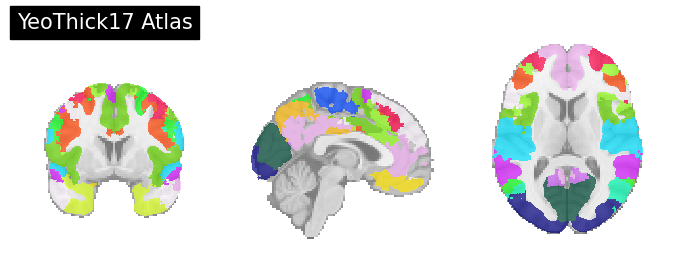

In [9]:
# Visualize parcellation atlas
plot_roi(yeo_thick17, draw_cross=False, annotate=False, title="YeoThick17 Atlas");

# Check the fit/shape of each of Yeo's ROI's

In [13]:
# Re-sample sub1 coc and pla files, and generate background images to plot each roi.

#sub1_coc_re_yeo = image.resample_to_img(sub1_coc, yeo_anat_img, interpolation='nearest')
#sub1_pla_re_yeo = image.resample_to_img(sub1_pla, yeo_anat_img, interpolation='nearest')

#sub1_coc_re_yeo_mean = image.mean_img(sub1_coc_re_yeo)
#sub1_pla_re_yeo_mean = image.mean_img(sub1_pla_re_yeo)

In [10]:
# So, I'm creating a mask for each roi/network in Yeo atlas and storing it in the variable below.
# Also, the loop below generates two images per roi (one using sub_1_coc as background and another one using sub_1_pla)
# each image is saved into folder Yeo_Roi_img.
yeo_roi_masks = []

for x in range(yeo_rois):
    
    print("Computing and plotting roi: " + str(yeo_labels[x]))
    roi_img = nl.image.new_img_like(yeo_thick17, nl.image.get_data(yeo_thick17) == x)
    masker = NiftiMasker(mask_img=roi_img, verbose=False).fit()
    yeo_roi_masks.append(masker)

    

Computing and plotting roi: N1_VIS1
Computing and plotting roi: N2_VIS2
Computing and plotting roi: N3_MOT1
Computing and plotting roi: N4_MOT2
Computing and plotting roi: N5_DORATT2
Computing and plotting roi: N6_DORATT1
Computing and plotting roi: N7_VAN1
Computing and plotting roi: N8_FP1
Computing and plotting roi: N9_LIM1
Computing and plotting roi: N10_LIM2
Computing and plotting roi: N11_FP2
Computing and plotting roi: N12_FP3
Computing and plotting roi: N13_FP4
Computing and plotting roi: N14_MOT3
Computing and plotting roi: N15_DMN1
Computing and plotting roi: N16_DMN3
Computing and plotting roi: N17_DMN2


# Estimating PC1 for each mask/roi

In [11]:
# Create Dataframe to store each participants PC1 scores. 

COC_PC1_Yeo_scores_df = pd.DataFrame(columns=yeo_labels2)
PLA_PC1_Yeo_scores_df = pd.DataFrame(columns=yeo_labels2)

zeros_holder = np.zeros((1, 17))

dir_path = os.getcwd()
dir_path += "/CANCOC_PP_1"

# Loop below for paticipants in "PP_1"
for path in os.listdir("CANCOC_PP_1"):
    #print(os.path.join(dir_path, path))
    if os.path.isdir(os.path.join(dir_path, path)): 
           
        current_p_df = pd.DataFrame(data=zeros_holder, columns=yeo_labels2, index=[path])
        COC_PC1_Yeo_scores_df = COC_PC1_Yeo_scores_df.append(current_p_df, ignore_index=False)
        PLA_PC1_Yeo_scores_df = PLA_PC1_Yeo_scores_df.append(current_p_df, ignore_index=False)

#PLA_PC1_Yeo_scores_df.head()


/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_3181/2307949637.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  COC_PC1_Yeo_scores_df = COC_PC1_Yeo_scores_df.append(current_p_df, ignore_index=False)
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_3181/2307949637.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PLA_PC1_Yeo_scores_df = PLA_PC1_Yeo_scores_df.append(current_p_df, ignore_index=False)
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_3181/2307949637.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  COC_PC1_Yeo_scores_df = COC_PC1_Yeo_scores_df.append(current_p_df, ignore_index=False)
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_3181/2307949637.py:18: Future

In [36]:
#sub1_PLA_PC1_scores = []
#sub2_PLA_PC1_scores = []
#sub3_PLA_PC1_scores = []
#sub4_PLA_PC1_scores = []
#sub5_PLA_PC1_scores = []
#sub6_PLA_PC1_scores = []
#sub7_PLA_PC1_scores = []
#sub8_PLA_PC1_scores = []
#sub9_PLA_PC1_scores = []
#sub10_PLA_PC1_scores = []
#sub11_PLA_PC1_scores = []
#sub12_PLA_PC1_scores = []
#sub13_PLA_PC1_scores = []
#sub14_PLA_PC1_scores = []
#sub15_PLA_PC1_scores = []
#sub16_PLA_PC1_scores = []
#sub17_PLA_PC1_scores = []
#sub18_PLA_PC1_scores = []
#sub19_PLA_PC1_scores = []
#sub20_PLA_PC1_scores = []
#sub21_PLA_PC1_scores = []
#sub22_PLA_PC1_scores = []
#sub23_PLA_PC1_scores = []
#sub24_PLA_PC1_scores = []
#sub25_PLA_PC1_scores = []
#sub26_PLA_PC1_scores = []
#sub27_PLA_PC1_scores = []
#sub28_PLA_PC1_scores = []
#sub29_PLA_PC1_scores = []
#sub30_PLA_PC1_scores = []
#sub31_PLA_PC1_scores = []
#sub32_PLA_PC1_scores = []
#sub33_PLA_PC1_scores = []
#sub34_PLA_PC1_scores = []
#sub35_PLA_PC1_scores = []
#sub36_PLA_PC1_scores = []
#sub37_PLA_PC1_scores = []
#sub38_PLA_PC1_scores = []
#sub39_PLA_PC1_scores = []
#sub40_PLA_PC1_scores = []


for current_roi in range(yeo_rois):
    
    #sub1_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[0]))
    #sub2_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[1]))
    #sub3_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[2]))
    #sub4_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[3]))
    #sub5_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[4]))
    #sub6_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[5]))
    #sub7_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[6]))
    #sub8_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[7]))
    #sub9_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[8]))
    #sub10_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[9]))
    #sub11_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[10]))
    #sub12_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[11]))
    #sub13_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[12]))
    #sub14_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[13]))
    #sub15_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[14]))
    #sub16_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[15]))
    #sub17_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[16]))
    #sub18_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[17]))
    #sub19_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[18]))
    #sub20_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[19]))
    #sub21_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[20]))
    #sub22_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[21]))
    #sub23_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[22]))
    #sub24_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[23]))
    #sub25_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[24]))
    #sub26_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[25]))
    #sub27_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[26]))
    #sub28_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[27]))
    #sub29_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[28]))
    #sub30_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[29]))
    #sub31_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[30]))
    #sub32_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[31]))
    #sub33_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[32]))
    #sub34_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[33]))
    #sub35_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[34]))
    #sub36_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[35]))
    #sub37_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[36]))
    #sub38_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[37]))
    #sub39_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[38]))
    #sub40_PLA_PC1_scores.append(fit_mask_get_PC1.remote(yeo_roi_masks[current_roi], PLA_paths[39]))


In [42]:
#sub1_PLA_scores = ray.get(sub1_PLA_PC1_scores)
#sub2_PLA_scores = ray.get(sub2_PLA_PC1_scores) 
#sub3_PLA_scores = ray.get(sub3_PLA_PC1_scores) 
#sub4_PLA_scores = ray.get(sub4_PLA_PC1_scores) 
#sub5_PLA_scores = ray.get(sub5_PLA_PC1_scores) 
#sub6_PLA_scores = ray.get(sub6_PLA_PC1_scores) 
#sub7_PLA_scores = ray.get(sub7_PLA_PC1_scores)
#sub8_PLA_scores = ray.get(sub8_PLA_PC1_scores) 
#sub9_PLA_scores = ray.get(sub9_PLA_PC1_scores)
#sub10_PLA_scores = ray.get(sub10_PLA_PC1_scores) 
#sub11_PLA_scores = ray.get(sub11_PLA_PC1_scores) 
#sub12_PLA_scores = ray.get(sub12_PLA_PC1_scores) 
#sub13_PLA_scores = ray.get(sub13_PLA_PC1_scores) 
#sub14_PLA_scores = ray.get(sub14_PLA_PC1_scores) 
#sub15_PLA_scores = ray.get(sub15_PLA_PC1_scores)
#sub16_PLA_scores = ray.get(sub16_PLA_PC1_scores) 
#sub17_PLA_scores = ray.get(sub17_PLA_PC1_scores)
#sub18_PLA_scores = ray.get(sub18_PLA_PC1_scores) 
#sub19_PLA_scores = ray.get(sub19_PLA_PC1_scores)
#sub20_PLA_scores = ray.get(sub20_PLA_PC1_scores)
#sub21_PLA_scores = ray.get(sub21_PLA_PC1_scores)
#sub22_PLA_scores = ray.get(sub22_PLA_PC1_scores)
#sub23_PLA_scores = ray.get(sub23_PLA_PC1_scores)
#sub24_PLA_scores = ray.get(sub24_PLA_PC1_scores)
#sub25_PLA_scores = ray.get(sub25_PLA_PC1_scores)
#sub26_PLA_scores = ray.get(sub26_PLA_PC1_scores)
#sub27_PLA_scores = ray.get(sub27_PLA_PC1_scores)
#sub28_PLA_scores = ray.get(sub28_PLA_PC1_scores)
#sub29_PLA_scores = ray.get(sub29_PLA_PC1_scores)
#sub30_PLA_scores = ray.get(sub30_PLA_PC1_scores)
#sub31_PLA_scores = ray.get(sub31_PLA_PC1_scores)
#sub32_PLA_scores = ray.get(sub32_PLA_PC1_scores)
#sub33_PLA_scores = ray.get(sub33_PLA_PC1_scores)
#sub34_PLA_scores = ray.get(sub34_PLA_PC1_scores)
#sub35_PLA_scores = ray.get(sub35_PLA_PC1_scores)
#sub36_PLA_scores = ray.get(sub36_PLA_PC1_scores)
#sub37_PLA_scores = ray.get(sub37_PLA_PC1_scores)
#sub38_PLA_scores = ray.get(sub38_PLA_PC1_scores)
#sub39_PLA_scores = ray.get(sub39_PLA_PC1_scores)
#sub40_PLA_scores = ray.get(sub40_PLA_PC1_scores)

#PLA_PC1_Yeo_scores_df.iloc[0] = sub1_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[1] = sub2_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[2] = sub3_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[3] = sub4_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[4] = sub5_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[5] = sub6_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[6] = sub7_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[7] = sub8_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[8] = sub9_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[9] = sub10_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[10] = sub11_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[11] = sub12_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[12] = sub13_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[13] = sub14_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[14] = sub15_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[15] = sub16_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[16] = sub17_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[17] = sub18_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[18] = sub19_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[19] = sub20_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[20] = sub21_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[21] = sub22_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[22] = sub23_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[23] = sub24_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[24] = sub25_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[25] = sub26_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[26] = sub27_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[27] = sub28_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[28] = sub29_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[29] = sub30_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[30] = sub31_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[31] = sub32_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[32] = sub33_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[33] = sub34_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[34] = sub35_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[35] = sub36_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[36] = sub37_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[37] = sub38_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[38] = sub39_PLA_scores[:]
#PLA_PC1_Yeo_scores_df.iloc[39] = sub40_PLA_scores[:]

#PLA_PC1_Yeo_scores_df.head(40)

In [13]:
COC_PC1_Yeo_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/YeoFIT_GMCOC_PC1_scores.csv', index_col=0)
PLA_PC1_Yeo_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/YeoFIT_GMPLA_PC1_scores.csv', index_col=0)

#PLA_PC1_Yeo_scores_df.to_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/YeoFIT_GMPLA_PC1_scores.csv')



In [51]:
#COC_PC1_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/YeoFIT_COC_PP1_scores_.csv', index_col=0)
#COC_PC2_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/YeoFIT_COC_PP2_scores.csv', index_col=0)
#PLA_PC1_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/YeoFIT_PLA_PP1_scores.csv', index_col=0)
#PLA_PC2_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/YeoFIT_PLA_PP2_scores.csv', index_col=0)


# Visualizing Results

### PP1 COC 

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


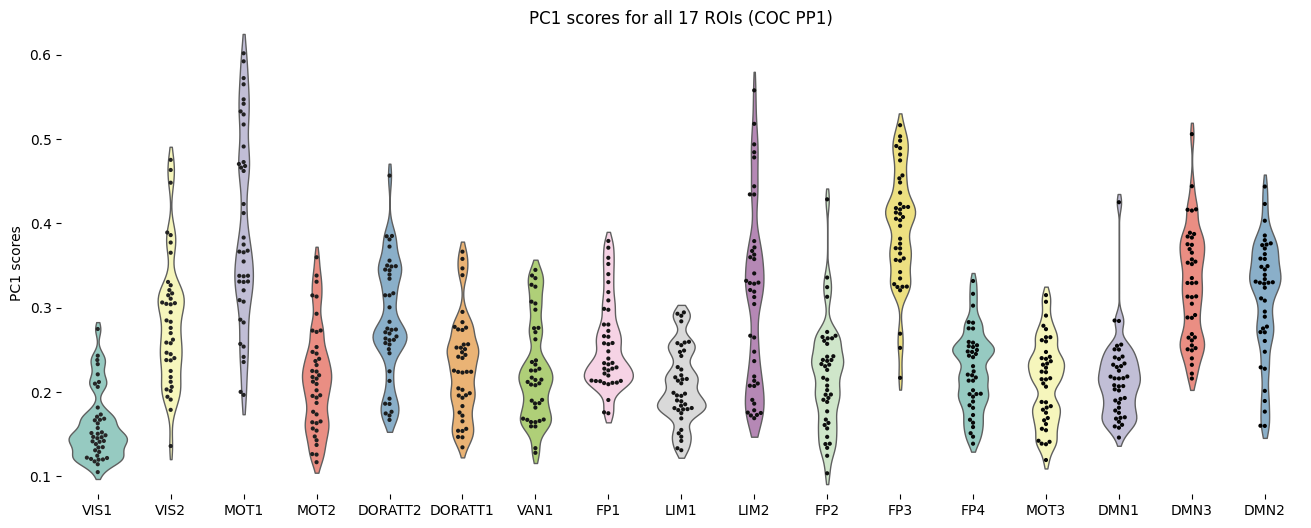

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 6))

#COC_PC1_scores_df2 = COC_PC1_scores_df
#COC_PC1_scores_df2.columns = yeo_labels2

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=COC_PC1_Yeo_scores_df, palette="Set3", bw=.2, cut=1, linewidth=1, inner=None)
sns.swarmplot(data=COC_PC1_Yeo_scores_df, color="k", size=3, ax=ax)
ax.set_title("PC1 scores for all 17 ROIs (COC PP1)")
ax.set(xlabel="", ylabel="PC1 scores")

# Finalize the figure
sns.despine(left=True, bottom=True)

In [15]:

COC_yeo_fit_avg = []
COC_yeo_fit_std = []

for x in range(yeo_rois):
    COC_yeo_fit_avg.append(COC_PC1_Yeo_scores_df[yeo_labels2[x]].iloc[0:17].mean())
    COC_yeo_fit_std.append(COC_PC1_Yeo_scores_df[yeo_labels2[x]].iloc[0:17].std())
    
#COC_yeo_fit_avg
    

In [16]:

yeo_masks_avg_fit_vis = []
yeo_masks_std_fit_vis = []

for x in range(yeo_rois):
    shit_another_mask = yeo_roi_masks[x].fit_transform(COC_paths[0])
    runner = shit_another_mask.shape[1]
    score_avg = COC_yeo_fit_avg[x]
    score_std = COC_yeo_fit_std[x]

    yeo_zeros_avg_mask = np.zeros((1, runner))
    yeo_zeros_std_mask = np.zeros((1, runner))

    yeo_zeros_avg_mask[0, :] = score_avg*100
    yeo_zeros_std_mask[0, :] = score_std*100

    yeo_masks_avg_fit_vis.append(yeo_roi_masks[x].inverse_transform(yeo_zeros_avg_mask))
    yeo_masks_std_fit_vis.append(yeo_roi_masks[x].inverse_transform(yeo_zeros_std_mask))
    
    

In [17]:
print("yeo_masks_avg_fit_vis shape: " + str(yeo_masks_avg_fit_vis[1].shape))
print("yeo_masks_std_fit_vis shape: " + str(yeo_masks_std_fit_vis[1].shape))


yeo_masks_avg_fit_vis shape: (256, 256, 256, 1)
yeo_masks_std_fit_vis shape: (256, 256, 256, 1)


In [18]:
# Make zero matrix (to get the shape right) ... then run for loop and sum all matrices.
zero_matrix = nl.image.get_data(yeo_masks_avg_fit_vis[0]).shape
COC_Yeo_avg_fit_vis = np.zeros((zero_matrix))
COC_Yeo_avg_std_fit_vis = np.zeros((zero_matrix))

# Run loop for times (number of rois). Each iteration get matrix with PC1 scores for that roi
# And add it to the "COC_AA_COC1_avg_fit_vis."
for x in range(yeo_rois):
    current_roi_scores_avg = nl.image.get_data(yeo_masks_avg_fit_vis[x])
    current_roi_scores_std = nl.image.get_data(yeo_masks_std_fit_vis[x])

    COC_Yeo_avg_fit_vis = COC_Yeo_avg_fit_vis + current_roi_scores_avg
    COC_Yeo_avg_std_fit_vis = COC_Yeo_avg_std_fit_vis + current_roi_scores_std

COC_Yeo_avg_fit_vis = nl.image.new_img_like(yeo_thick17, COC_Yeo_avg_fit_vis)
COC_Yeo_avg_std_fit_vis = nl.image.new_img_like(yeo_thick17, COC_Yeo_avg_std_fit_vis)

# Save vol file as ...
COC_Yeo_avg_fit_vis.to_filename("Yeo_AveragePC1Scores_COC.nii.gz")
COC_Yeo_avg_std_fit_vis.to_filename("Yeo_STDPC1Scores_COC.nii.gz")


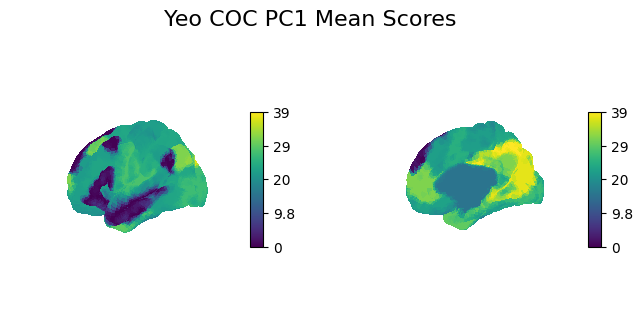

In [19]:
from matplotlib import cm

fsaverage = datasets.fetch_surf_fsaverage()

texture_pial_right = surface.vol_to_surf(COC_Yeo_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=10, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(COC_Yeo_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=10, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("Yeo COC PC1 Mean Scores", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
#plt.close()
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True, cmap='viridis', axes=axs2) 
plt.show()

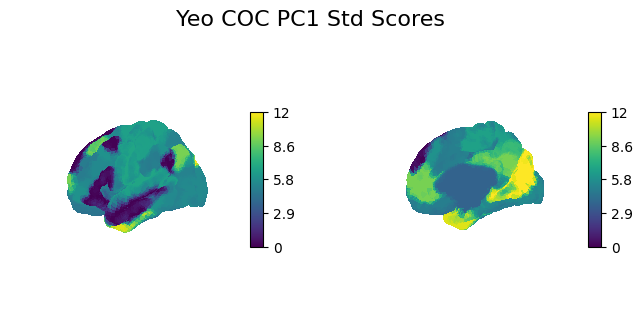

In [20]:

texture_pial_right = surface.vol_to_surf(COC_Yeo_avg_std_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=10, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(COC_Yeo_avg_std_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=10, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("Yeo COC PC1 Std Scores", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
#plt.close()
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True, cmap='viridis', axes=axs2) 
plt.show()

### PP1 PLA

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


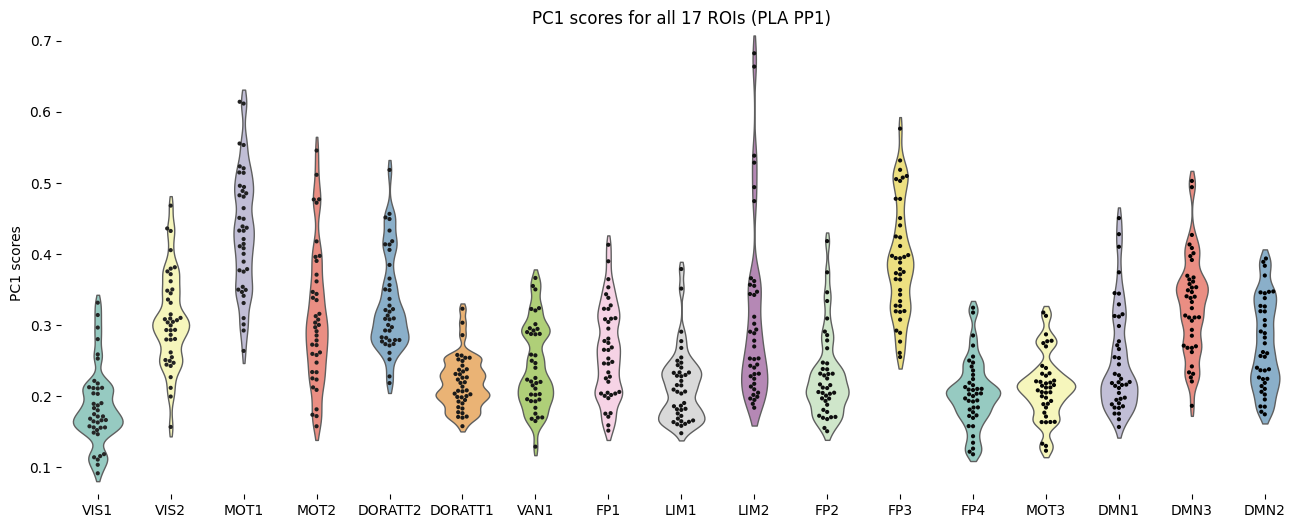

In [22]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=PLA_PC1_Yeo_scores_df, palette="Set3", bw=.2, cut=1, linewidth=1, inner=None)
sns.swarmplot(data=PLA_PC1_Yeo_scores_df, color="k", size=3, ax=ax)
ax.set_title("PC1 scores for all 17 ROIs (PLA PP1)")
ax.set(xlabel="", ylabel="PC1 scores")

# Finalize the figure
sns.despine(left=True, bottom=True)

In [26]:
PLA_yeo_fit_avg = []
PLA_yeo_fit_std = []

for x in range(yeo_rois):
    PLA_yeo_fit_avg.append(PLA_PC1_Yeo_scores_df[yeo_labels2[x]].iloc[0:17].mean())
    PLA_yeo_fit_std.append(PLA_PC1_Yeo_scores_df[yeo_labels2[x]].iloc[0:17].std())
    

In [28]:
yeo_masks_pla_avg_fit_vis = []
yeo_masks_pla_std_fit_vis = []

for x in range(yeo_rois):
    shit_another_mask = yeo_roi_masks[x].fit_transform(PLA_paths[0])
    runner = shit_another_mask.shape[1]
    score_avg = PLA_yeo_fit_avg[x]
    score_std = PLA_yeo_fit_std[x]

    yeo_zeros_mask_avg = np.zeros((1, runner))
    yeo_zeros_mask_std = np.zeros((1, runner))

    yeo_zeros_mask_avg[0, :] = score_avg*100
    yeo_zeros_mask_std[0, :] = score_std*100

    yeo_masks_pla_avg_fit_vis.append(yeo_roi_masks[x].inverse_transform(yeo_zeros_mask_avg))
    yeo_masks_pla_std_fit_vis.append(yeo_roi_masks[x].inverse_transform(yeo_zeros_mask_std))
    



In [29]:
print("yeo_masks_pla_avg_fit_vis shape: " + str(yeo_masks_pla_avg_fit_vis[1].shape))
print("yeo_masks_pla_std_fit_vis shape: " + str(yeo_masks_pla_std_fit_vis[1].shape))

yeo_masks_pla_avg_fit_vis shape: (256, 256, 256, 1)
yeo_masks_pla_std_fit_vis shape: (256, 256, 256, 1)


In [30]:
# Make zero matrix (to get the shape right) ... then run for loop and sum all matrices.
zero_matrix = nl.image.get_data(yeo_masks_pla_avg_fit_vis[0]).shape
PLA_Yeo_pla_avg_fit_vis = np.zeros((zero_matrix))
PLA_Yeo_pla_std_fit_vis = np.zeros((zero_matrix))

# Run loop for times (number of rois). Each iteration get matrix with PC1 scores for that roi
# And add it to the "PLA_AA_COC1_avg_fit_vis."
for x in range(yeo_rois):
    current_roi_scores_avg = nl.image.get_data(yeo_masks_pla_avg_fit_vis[x])
    current_roi_scores_std = nl.image.get_data(yeo_masks_pla_std_fit_vis[x])        

    PLA_Yeo_pla_avg_fit_vis = PLA_Yeo_pla_avg_fit_vis + current_roi_scores_avg
    PLA_Yeo_pla_std_fit_vis = PLA_Yeo_pla_std_fit_vis + current_roi_scores_std

PLA_Yeo_avg_fit_vis = nl.image.new_img_like(yeo_thick17, PLA_Yeo_pla_avg_fit_vis)
PLA_Yeo_std_fit_vis = nl.image.new_img_like(yeo_thick17, PLA_Yeo_pla_std_fit_vis)

# Save vol file as ...
PLA_Yeo_avg_fit_vis.to_filename("Yeo_AveragePC1Scores_PLA.nii.gz")
PLA_Yeo_std_fit_vis.to_filename("Yeo_StdPC1Scores_PLA.nii.gz")

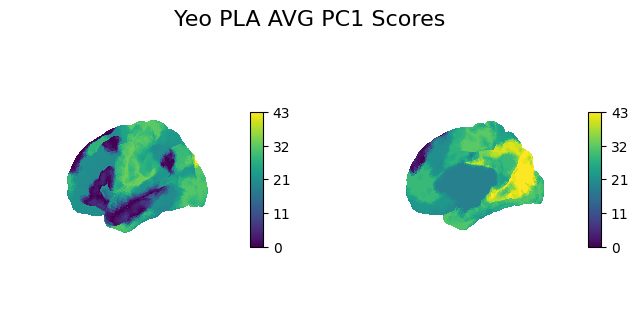

In [31]:
texture_pial_right = surface.vol_to_surf(PLA_Yeo_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=5, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(PLA_Yeo_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=5, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("Yeo PLA AVG PC1 Scores", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
#plt.close()
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True,  cmap='viridis', axes=axs2) 
plt.show()

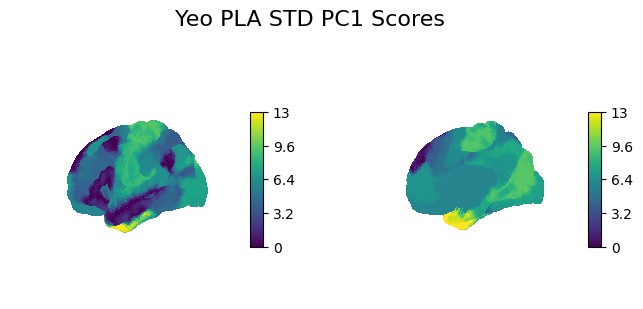

In [32]:
texture_pial_right = surface.vol_to_surf(PLA_Yeo_std_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=5, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(PLA_Yeo_std_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=5, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("Yeo PLA STD PC1 Scores", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
#plt.close()
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True,  cmap='viridis', axes=axs2) 
plt.show()

## Change scores (COC - PLA) (All)

In [33]:
# Create new df with change scores for each participant and each roi. 
Change_PC1_Yeo_scores_df = pd.DataFrame(columns=yeo_labels2, index=COC_PC1_Yeo_scores_df.index)

for x in range(40):
    Change_PC1_Yeo_scores_df.iloc[x] = COC_PC1_Yeo_scores_df.iloc[x] - PLA_PC1_Yeo_scores_df.iloc[x]

Change_PC1_Yeo_scores_df.head()


,VIS1,VIS2,MOT1,MOT2,DORATT2,DORATT1,VAN1,FP1,LIM1,LIM2,FP2,FP3,FP4,MOT3,DMN1,DMN3,DMN2
P5259,-0.081896,-0.067717,0.121993,-0.253067,-0.188846,-0.110063,-0.120549,-0.076567,-0.007017,-0.023377,-0.041086,0.00099,0.103534,0.027073,-0.001196,0.110008,0.041661
P5232,-0.100785,0.003222,0.000153,-0.069462,-0.110562,-0.020997,-0.068786,-0.054282,-0.033509,-0.070836,-0.152417,0.11724,0.009794,-0.092656,-0.036922,-0.09589,0.109096
P5235,-0.001227,-0.021678,-0.313839,0.028042,0.087013,0.045844,0.057458,0.125683,0.136315,-0.027797,0.033708,-0.048439,0.027813,0.04503,-0.024535,0.127087,-0.007075
P5203,-0.022235,-0.157335,-0.037544,-0.195566,0.002633,-0.091483,-0.162145,-0.147741,-0.065948,0.007789,0.060505,-0.29298,0.001523,-0.076493,-0.022694,-0.20499,-0.159449
P5258,0.053901,-0.090604,-0.032103,-0.089934,0.052386,-0.001429,0.02148,-0.045977,-0.001543,-0.05876,-0.000591,-0.025496,0.032235,-0.066117,0.090202,-0.132199,-0.092075


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


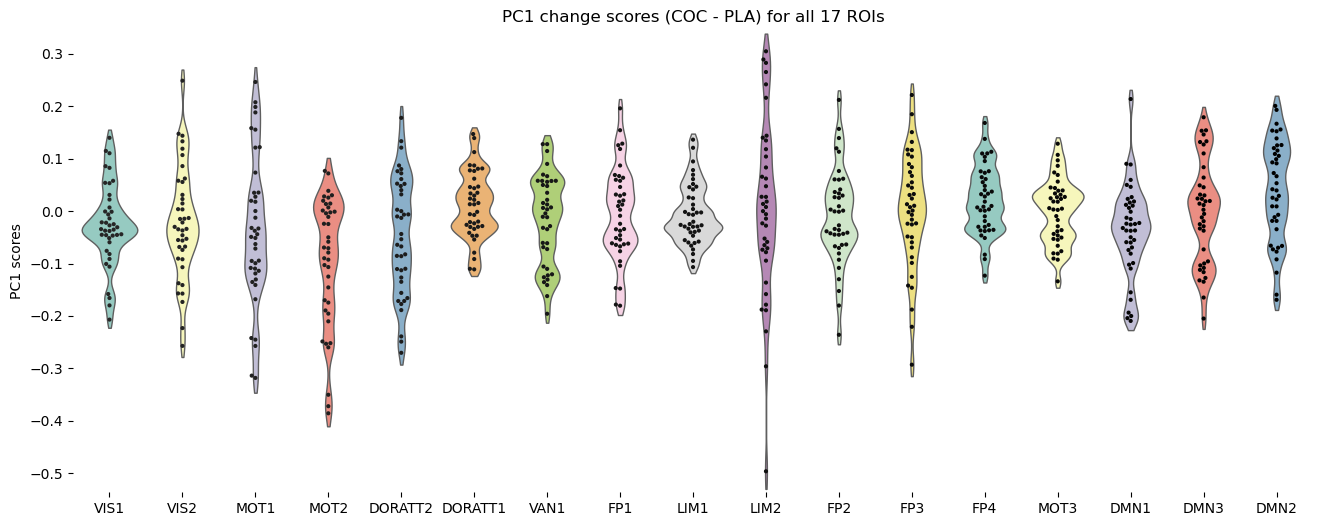

In [54]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=Change_PC1_Yeo_scores_df, palette="Set3", bw=.2, cut=1, linewidth=1, inner=None)
sns.swarmplot(data=Change_PC1_Yeo_scores_df, color="k", size=3, ax=ax)
ax.set_title("PC1 change scores (COC - PLA) for all 17 ROIs")
ax.set(xlabel="", ylabel="PC1 scores")

# Finalize the figure
sns.despine(left=True, bottom=True)

In [34]:
ChangeGM_Yeo_avg_fit = []
ChangeGM_Yeo_std_fit = []

for x in range(len(yeo_labels2)):
    ChangeGM_Yeo_avg_fit.append(Change_PC1_Yeo_scores_df[yeo_labels2[x]].mean(skipna=True))
    ChangeGM_Yeo_std_fit.append(Change_PC1_Yeo_scores_df[yeo_labels2[x]].std(skipna=True))
    

In [36]:
yeo_masks_change_avg_fit_vis = []
yeo_masks_change_std_fit_vis = []

for x in range(yeo_rois):
    shit_another_mask = yeo_roi_masks[x].fit_transform(PLA_paths[0])
    runner = shit_another_mask.shape[1]
    score_avg = ChangeGM_Yeo_avg_fit[x]
    score_std = ChangeGM_Yeo_std_fit[x]

    yeo_zeros_avg_mask = np.zeros((1, runner))
    yeo_zeros_std_mask = np.zeros((1, runner))

    yeo_zeros_avg_mask[0, :] = score_avg*100
    yeo_zeros_std_mask[0, :] = score_std*100

    yeo_masks_change_avg_fit_vis.append(yeo_roi_masks[x].inverse_transform(yeo_zeros_avg_mask))
    yeo_masks_change_std_fit_vis.append(yeo_roi_masks[x].inverse_transform(yeo_zeros_std_mask))



In [40]:
print("yeo_masks_change_avg_fit_vis shape: " + str(yeo_masks_change_avg_fit_vis[1].shape))
print("yeo_masks_change_std_fit_vis shape: " + str(yeo_masks_change_std_fit_vis[1].shape))

yeo_masks_change_avg_fit_vis shape: (256, 256, 256, 1)
yeo_masks_change_std_fit_vis shape: (256, 256, 256, 1)


In [42]:
# Make zero matrix (to get the shape right) ... then run for loop and sum all matrices.
zero_matrix_change_avg = nl.image.get_data(yeo_masks_change_avg_fit_vis[0]).shape
zero_matrix_change_std = nl.image.get_data(yeo_masks_change_std_fit_vis[0]).shape

ChangeAvg_Yeo_avg_fit_vis = np.zeros((zero_matrix_change_avg))
ChangeStd_Yeo_std_fit_vis = np.zeros((zero_matrix_change_std))

# Run loop for times (number of rois). Each iteration get matrix with PC1 scores for that roi
# And add it to the "PLA_AA_COC1_avg_fit_vis."
for x in range(yeo_rois):
    current_roi_scores_avg = nl.image.get_data(yeo_masks_change_avg_fit_vis[x])
    current_roi_scores_std = nl.image.get_data(yeo_masks_change_std_fit_vis[x])

    ChangeAvg_Yeo_avg_fit_vis = ChangeAvg_Yeo_avg_fit_vis + current_roi_scores_avg
    ChangeStd_Yeo_std_fit_vis = ChangeStd_Yeo_std_fit_vis + current_roi_scores_std

Change_Yeo_avg_fit_vis = nl.image.new_img_like(yeo_thick17, ChangeAvg_Yeo_avg_fit_vis)
Change_Yeo_std_fit_vis = nl.image.new_img_like(yeo_thick17, ChangeStd_Yeo_std_fit_vis)

# Save vol file as ...
Change_Yeo_avg_fit_vis.to_filename("Yeo_AveragePC1Scores_Change.nii.gz")
Change_Yeo_std_fit_vis.to_filename("Yeo_StdPC1Scores_Change.nii.gz")

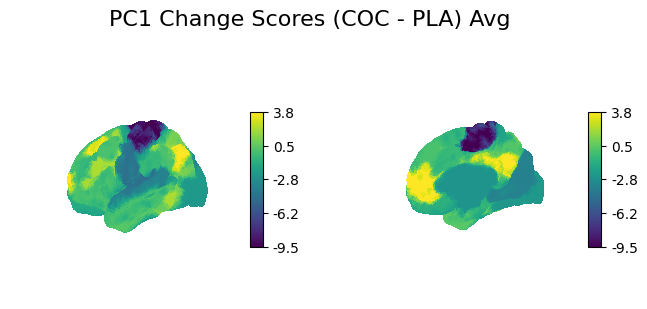

In [45]:
texture_pial_right = surface.vol_to_surf(Change_Yeo_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=5, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(Change_Yeo_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=5, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("PC1 Change Scores (COC - PLA) Avg", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
#plt.close()
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True,  cmap='viridis', axes=axs2) 
plt.show()

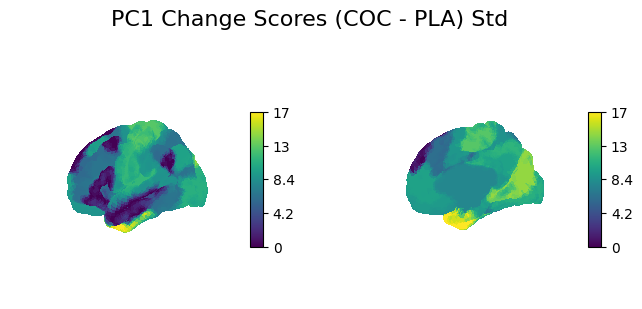

In [46]:
texture_pial_right = surface.vol_to_surf(Change_Yeo_std_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=5, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(Change_Yeo_std_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=5, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("PC1 Change Scores (COC - PLA) Std", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
#plt.close()
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True,  cmap='viridis', axes=axs2) 
plt.show()